In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

2.2.0+cu118
2.2.0+cu118


In [32]:
sample_rate

32000

In [33]:
92096 / 32000

2.878

In [7]:
waveform, sample_rate = torchaudio.load(
    "../../data/birdclef-2024/train_audio/aspfly1/XC288095.ogg"
)
transform = torchaudio.transforms.MelSpectrogram(sample_rate)
mel_spectrogram = transform(waveform).numpy()
pseudo_rgb_spectrogram = np.repeat(mel_spectrogram[..., np.newaxis], 3, axis=-1)

/home/lex/miniconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
waveform.shape[1]

104640

In [14]:
waveform[:, int(waveform.shape[1] * 0.1) : waveform.shape[1]]

tensor([[-3.3105e-02,  4.6828e-02,  1.0316e-01,  ..., -7.6963e-06,
          8.7922e-06,  2.1860e-06]])

In [12]:
Audio(waveform[0], rate=sample_rate)

In [27]:
torch.randint(0, 3, (1,)).item()

tensor([1])

In [15]:
duration = len(waveform[0]) / sample_rate

while duration < 5:
    waveform = torch.cat(
        (waveform, waveform[:, int(waveform.shape[1] * 0.1) : waveform.shape[1]]), dim=1
    )
    duration = len(waveform[0]) / sample_rate

In [16]:
Audio(waveform[0], rate=sample_rate)

In [31]:
waveform.shape

torch.Size([1, 92096])

In [23]:
# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(waveform)


melspec = T.AmplitudeToDB()(spec)

In [25]:
plot_spectrogram(melspec, title="spectrogram")

NameError: name 'plot_spectrogram' is not defined

In [49]:
# if len(pseudo_rgb_spectrogram.shape) > 1:  # Handle multi-channel audio if needed
#     pseudo_rgb_spectrogram = librosa.power_to_db(pseudo_rgb_spectrogram, ref=np.max)

In [16]:
pseudo_rgb_spectrogram = pseudo_rgb_spectrogram.squeeze()

In [27]:
pseudo_rgb_spectrogram.shape

(128, 461, 3)

In [28]:
pseudo_rgb_spectrogram = librosa.power_to_db(melspec, ref=np.max)

In [29]:
pseudo_rgb_spectrogram

array([[[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]]], dtype=float32)

TypeError: Invalid shape (1, 257, 360) for image data

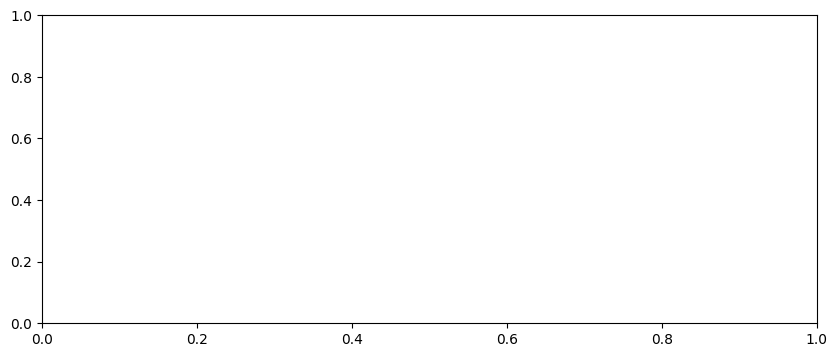

In [30]:
plt.figure(figsize=(10, 4))
plt.imshow(
    pseudo_rgb_spectrogram,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
)  # Use a suitable colormap
# plt.colorbar(label="Amplitude (dB)")
# plt.xlabel("Time")
# plt.ylabel("Mel Frequency")
# plt.title("Mel Spectrogram")
# plt.tight_layout()
plt.show()

In [7]:
n_fft = 2028
hop_length = 512
n_mels = 128
waveform, sample_rate = torchaudio.load(
    "../../data/birdclef-2024/train_audio/bkrfla1/XC116440.ogg"
)


class DataProcessing:
    @staticmethod
    def record_to_frames(waveform, sample_rate, frame_size=5):
        p1d = (1, sample_rate * frame_size)
        out = torch.nn.functional.pad(waveform, p1d, "constant", 0)
        return out.unfold(0, sample_rate * frame_size, sample_rate * frame_size)

    @staticmethod
    def my_collate(batch):
        frames = []
        labels = []
        for data, label in batch:
            waveform, sample_rate, name = data
            l_frames = DataProcessing.record_to_frames(waveform, sample_rate)

            for index in range(l_frames.size()[0]):
                frame = l_frames[index]
                # audio_spectogram = spectogram(frame)
                # audio_spectogram = audio_spectogram.repeat(3, 1, 1)
                frames.append((frame, sample_rate, f"{name}_{index}"))
                labels.append(label)
        return [frames, labels]

    @staticmethod
    def melgram(audio, sample_rate, to_file):
        # librosa.power_to_db(specgram),
        # origin="lower",
        # aspect="auto",
        # interpolation="nearest",
        plt.figure(figsize=(4, 2))
        plt.axis("off")  # no axis
        plt.axes(
            [0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[], yticks=[]
        )  # Remove the white edge
        melspectrogram = librosa.feature.melspectrogram(
            y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        plt.imshow(
            librosa.power_to_db(melspectrogram, ref=np.max),
            origin="lower",
            aspect="auto",
            interpolation="nearest",  # prevent blurring
        )
        # librosa.display.specshow(
        #     librosa.power_to_db(
        #         melspectrogram,
        #         ref=np.max,
        #     ),
        #     # origin="lower",
        #     # aspect="auto",
        #     # interpolation="nearest",
        # )
        plt.savefig(to_file, bbox_inches=None, pad_inches=0)
        plt.close()

In [8]:
DataProcessing.melgram(
    waveform[0].numpy(), sample_rate, f"{n_fft}_{hop_length}_{n_mels}.png"
)

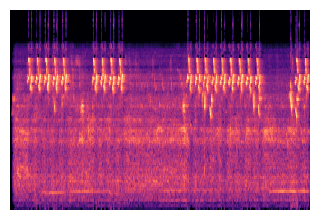

In [26]:
plt.figure(figsize=(3, 2))
plt.axis("off")  # no axis
plt.axes(
    [0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[], yticks=[]
)  # Remove the white edge
melspectrogram = librosa.feature.melspectrogram(y=waveform.numpy(), sr=sample_rate)

# height = S.shape[0]
# image_cropped = S[int(height*0.2  ):int(height*0.8 ),:]
librosa.display.specshow(
    librosa.power_to_db(
        melspectrogram.unfold(0, sample_rate * frame_size, sample_rate * frame_size),
        ref=np.max,
    )
)

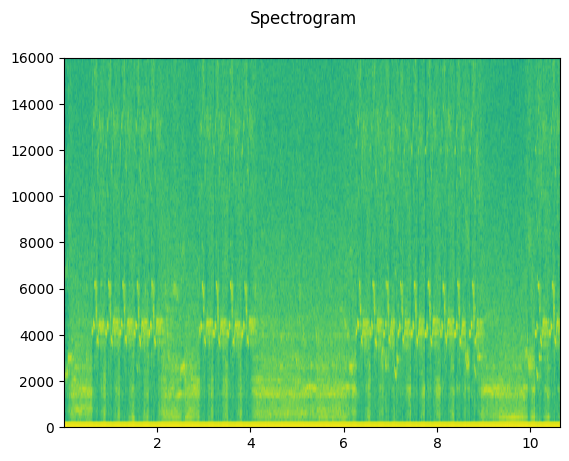

In [13]:
plot_specgram2(waveform, sample_rate)
# plot_spectrogram(waveform, title="spectrogram", ax=axs[1])
# fig.tight_layout()

In [8]:
print(torchaudio.get_audio_backend())

None


/tmp/ipykernel_28220/1222787529.py:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  print(torchaudio.get_audio_backend())


In [5]:
!pip install sox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40039 sha256=065396ee4ad6c404c15199dc90a98dab9a93b5f861438903eda4968336103979
  Stored in directory: /home/lex/.cache/pip/wheels/74/89/93/023fcdacaec4e5471e78b43992515e8500cc2505b307e2e6b7
Successfully built sox
